**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
import numba as nb
from types import SimpleNamespace
from scipy import optimize
from scipy.optimize import minimize
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import sympy as sm

# Importing our own code
import problem1
import problem2

# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

## <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

**Answer for question 1:**
$$
\begin{align*}
V(w,\tau,G)=\underset{L\epsilon[0,24]}{max}ln(C^{\alpha}G^{1-\alpha})-\upsilon\frac{L^{2}}{2}\rightarrow \\
V(\overset{\sim}{\omega})=ln[(\kappa+\overset{\sim}{\omega}L)^{\alpha}G^{1-\alpha}]-\upsilon\frac{L^{2}}{2}
\end{align*}
$$
FOC: 
$$
\begin{align*}
\frac{\partial V(\overset{\sim}{\omega})}{\partial L}=0:\rightarrow \\
\frac{1}{(\kappa+\overset{\sim}{\omega}L)^{\alpha}G^{1-\alpha}}\cdot\alpha(\kappa+\overset{\sim}{\omega}L)^{\alpha-1}\cdot G^{1-\alpha}=\upsilon L\rightarrow \\
\frac{\alpha\overset{\sim}{\omega}(\kappa+\overset{\sim}{\omega}L)^{\alpha-1}}{(\kappa+\overset{\sim}{\omega}L)^{\alpha}}=\upsilon L\rightarrow \\
\frac{\alpha\overset{\sim}{\omega}}{\kappa+\overset{\sim}{\omega}L}=\upsilon L\rightarrow \\
\alpha\overset{\sim}{\omega}=\upsilon L(\kappa+\overset{\sim}{\omega}L)\rightarrow \\
\overset{\sim}{\omega}L^{2}+\kappa L-\frac{\alpha\overset{\sim}{\omega}}{\upsilon}=0
\end{align*}
$$

2nd degree polynomial:
$$
\begin{align*}
d=\kappa^{2}+4\cdot\overset{\sim}{\omega}\cdot\frac{\alpha\overset{\sim}{\omega}}{\upsilon}=\kappa^{2}+4\overset{\sim}{\omega}^{2}\frac{\alpha}{\upsilon} \\
L=\frac{-\kappa\pm\sqrt{\kappa^{2}+4\cdot\frac{\alpha}{\upsilon}\cdot\overset{\sim}{\omega}^{2}}}{2\cdot\overset{\sim}{\omega}}
\end{align*}
$$
We cannot subtract as labor supply would then be negative. Hence: 
$$
\begin{align*}
L(\overset{\sim}{\omega})=\frac{-\kappa+\sqrt{\kappa^{2}+4\cdot\frac{\alpha}{\upsilon}\cdot\overset{\sim}{\omega}^{2}}}{2\cdot\overset{\sim}{\omega}}
\end{align*}
$$


**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

**Answer for question 2:**

In [2]:
alpha = 0.5
kappa = 1.0
upsilon = 1/(2*16**2)
omega_vec = np.linspace(0.8,1.2,5)

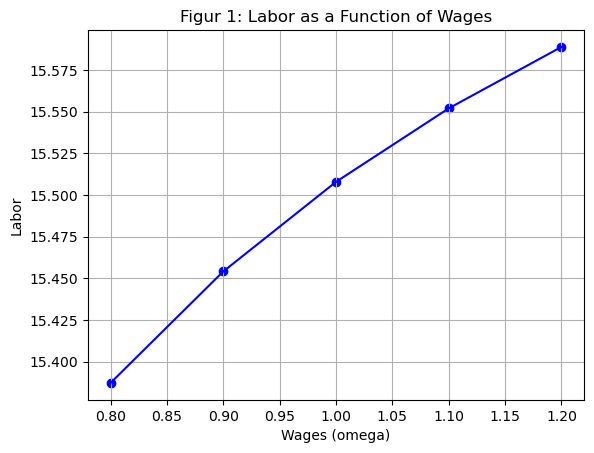

In [3]:
# Calculating labor for each omega (wage) value
labor = {}
for omega in omega_vec:
    L = (-kappa + np.sqrt(kappa**2+4*alpha/upsilon*omega**2))/(2*omega)
    labor[omega] = L

# Plotting
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(omega_vec, labor.values(), color='blue')
ax.scatter(omega_vec, labor.values(), color='blue')

ax.grid()
ax.set_xlabel("Wages (omega)")
ax.set_ylabel("Labor")
ax.set_title("Figur 1: Labor as a Function of Wages")
plt.show()


- Figure 1 illustrates that when wages increase, the labor supply increase. 


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


**Answer for question 3:**

In [4]:
# Import taxation class model 
from problem1 import TaxationClass
model1 = TaxationClass()
par = model1.par
sol = model1.sol

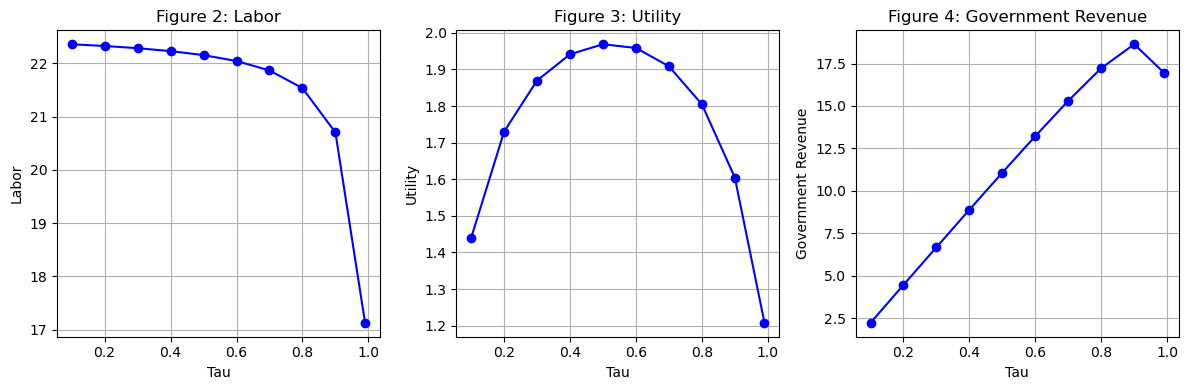

In [5]:
# Solutions for different tau-values
tau_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
labor = {}
utility = {}
government = {}

for tau in tau_list:
    par.tau = tau
    opt = model1.solve()

    labor[tau] = opt.labor 
    utility[tau] = model1.calc_utility(labor=opt.labor)
    government[tau] = model1.government(labor=opt.labor)

tau_values = list(labor.keys())
labor_values = list(labor.values())
utility_values = list(utility.values())
government_values = list(government.values())

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Labor
axs[0].plot(tau_values, labor_values, color='blue', linestyle='-', marker='o', label='Simulated')
axs[0].set(xlabel='Tau', ylabel='Labor')
axs[0].set_title('Figure 2: Labor')
axs[0].grid(True)

# Utility
axs[1].plot(tau_values, utility_values, color='blue', linestyle='-', marker='o', label='Simulated')
axs[1].set(xlabel='Tau', ylabel='Utility')
axs[1].set_title('Figure 3: Utility')
axs[1].grid(True)

# Government revenue
axs[2].plot(tau_values, government_values, color='blue', linestyle='-', marker='o', label='Simulated')
axs[2].set(xlabel='Tau', ylabel='Government Revenue')
axs[2].set_title('Figure 4: Government Revenue')
axs[2].grid(True)

fig.tight_layout()
plt.show()


- Figure 2 illustrates a clear relationship between taxes and labor supply, showing that as taxes increase, the labor supply decreases. This suggests that higher tax rates can have a reducing effect on workforce participation. 
- In Figure 3, we observe the concave nature of workers' utility as a function of the tax rate. The graph illustrates that workers tend to experience the highest level of utility at a tax rate of approximately $\tau$=0.5. 
- Examining Figure 4, we explore the relationship between tax rates and government revenue. The graph reveals that higher tax rates correspond to higher government revenue up until around $\tau$=0.9. This implies that the government can generate increased funding for public expenditures by implementing higher tax rates below 0.9. 
- At this point, all things equal, the tax rate start to depress government revenue and the higher tax rates discourage work and reduce labor supply. As labor supply decreases, taxable income also decreases, resulting in lower revenue for the government.

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

**Answer for question 3:** 
- In the "problem1.py" we have created a TaxationClass that allow us to analyze the effects of different tax rates on utility maximization. The aim is to find the tax rate that maximizes utility for individuals under various scenarios.

- In the TaxationClass we have built in consumption, government spending, and utility functions based on a given labor input. The consumption function takes into account the tax rate and calculates the available consumption level. The government function determines the government spending based on the tax rate and labor input. The utility function calculates the utility of individuals based on consumption, government spending and other parameters.

- To find the optimal labor input that maximizes utility, we solve by using the negative of the minimize function from scipy. By varying the tax rate as an input, the method iteratively solves for the optimal labor input and maximizes utility. The Nelder-Mead method is used for optimization, and the result is the tax rate ($\tau$) that yields the highest utility. As per below result we find the optimal tax rate to be 0.52.


In [6]:
model1.optimal_tax(do_print=True) # We negate the value in the TaxationClass because it represents a minimizer.

Optimization terminated successfully.
tau_hat: 0.52
Utility value: 1.97


A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

**Answer for question 5:**

In [7]:
# Model based on set 1 parameters and optimal tax from question 4
from problem1 import TaxationClass
model1_new1 = TaxationClass()
par = model1_new1.par
sol = model1_new1.sol
model1_new1.par.sigma = 1.001
model1_new1.par.rho = 1.001
model1_new1.par.tau = 0.5226

In [8]:
opt_new1 = model1_new1.solve()
labor_new1 = opt_new1.labor 
utility_new1 = model1_new1.calc_utility(opt_new1.labor)
government_new1 = model1_new1.government(opt_new1.labor)

print("Set 1: ")
print("Optimal Labor:       {:.2f}".format(labor_new1))
print("Utility:             {:.2f}".format(utility_new1))
print("Government Revenue:  {:.2f}".format(government_new1))

Set 1: 
Optimal Labor:       22.11
Utility:             1.97
Government Revenue:  11.55


In [9]:
# Model based on set 2 parameters and optimal tax from question 4
from problem1 import TaxationClass
model1_new2 = TaxationClass()
par = model1_new2.par
sol = model1_new2.sol
model1_new2.par.sigma = 1.5
model1_new2.par.rho = 1.5
model1_new2.par.tau = 0.5226

In [10]:
opt_new2 = model1_new2.solve()
labor_new2 = opt_new2.labor 
utility_new2 = model1_new2.calc_utility(opt_new2.labor)
government_new2 = model1_new2.government(opt_new2.labor)

print("Set 2: ")
print("Optimal Labor:       {:.2f}".format(labor_new2))
print("Utility:             {:.2f}".format(utility_new2))
print("Government Revenue:  {:.2f}".format(government_new2))

Set 2: 
Optimal Labor:       13.35
Utility:             1.08
Government Revenue:  6.97


- The optimal labor, utility and government revenue decreases as a result changing the parameters from set 1 to set 2. The intuition from this is the parameter values in set 1: $\sigma = 1.001$, $\rho = 1.001$, and $\varepsilon = 1.0$ approach values very close to 1, which is the characteristic of a Cobb-Douglas function. 
- A Cobb-Douglas utility function exhibits constant elasticity of substitution and constant returns to scale, where the marginal rates of substitution and transformation are constant. 

- In Set 2, the parameter values $\sigma = 1.5$, $\rho = 1.5$, and $\varepsilon = 1.0$ indicate a CES utility function. This allows for varying degrees of substitutability between different inputs, wherefor the labor supply elasticity is higher than in a Cobb-Douglas function. 
- The higher values of $\sigma$ and $\rho$ indicates a higher degree of substitution between labor and government consumption, resulting in the lower labor supply, utility, and government revenue compared to Set 1.


**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

**Answer for question 6:**

In [11]:
print("Set 1: ")
model1_new1.optimal_tax(do_print=True) 

Set 1: 
Optimization terminated successfully.
tau_hat: 0.52
Utility value: 1.97


In [12]:
print("Set 2: ")
model1_new2.optimal_tax(do_print=True) 

Set 2: 
Optimization terminated successfully.
tau_hat: 0.54
Utility value: 1.08


- We notice that the optimal tax rate with Set 1 parameters is 0.52 and thereby identical with the taxrate from the baseline model. The same for the utility value. This can be attributed to the fact that the parameters are approximately the same. 
- In the model with Set 2, individuals become more sensitive to changes in the relative prices between consumption and working/or not working. 
- This increased sensitivity leads to a higher degree of substitution between labor and government consumption, resulting in a lower optimal tax rate and lower utility value compared to the baseline model. 
- Additionally, individuals in Set 2 are more sensitive to changes in the tax rate, which influences their labor supply decisions and consequently their utility.

## <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

We use sympa to verify the term that maximizes profits. 

**Answer for question 1:**

In [13]:
eta = sm.symbols('eta')
w = sm.symbols('w')
kappa = sm.symbols('kappa_t')
l = sm.symbols('l_t') 
Pi = sm.symbols('\prod')

In [14]:
objective = kappa*l**(1-eta) -(w*l)
foc = sm.diff(objective,l)
sol = sm.solve(sm.Eq(foc,0), l)
sol[0]

(kappa_t*(1 - eta)/w)**(1/eta)

We define a firm function to determine labor, price and profits when $\kappa$=1 and $\kappa$=2. 

In [15]:
# Find numerical answers
def firm(eta,w,kappa):
    
    p = lambda l: kappa*(l**-eta)
    obj = lambda l: -(p(l)*l-w*l)
    x0 = [0.5]
    res = optimize.minimize(obj,x0,bounds=((0,None),),method='L-BFGS-B')

    # b. save
    l_star = res.x[0]
    p_star = p(l_star)
    Pi = (p_star*l_star) - w*l_star

    return l_star, p_star, Pi

In [16]:
for kappa in [1.0,2.0]:
    l,p,Pi = firm(0.5,1.0,kappa)
    print(f'kappa = {kappa:.2f} -> l = {l:.2f},  p = {p:.2f}, Pi = {Pi:.2f}')

kappa = 1.00 -> l = 0.25,  p = 2.00, Pi = 0.25
kappa = 2.00 -> l = 1.00,  p = 2.00, Pi = 1.00


We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

**Answer for question 2:**
We have set up the code to solve this problem in the py-file "problem 2." For full documentation, see this file.
We have done the following: 

-  Defined a class demandclass with 5 sub functions:
     1. Define parameters
     2. Defined the kappa (demand shock function)
     3. Defined  the policy function
     4. Defined the profit function
     5. Defined a simulation function in which we calculate the ex ante expected value of the salon. 
     
- In the simulation function, we calculate profits in each period $t$ for K iterations with different $\epsilon$-values. We first sum over the $t$ periods and take the average for the $K$ iterations. 
-  NOTE: We do not think that our results in the following are correct. First of all, we are unsure of how to incorperate logs and exponentials in an AR(1)-process. We think that as $\kappa$ is log-normal, we need to take the exponential to the right hand side of the AR(1)-equation. As logs and exponentials cancel each other out, we have not done antyhing to the $\kappa_{t-1}$-term but just taken an exponential to the $\epsilon_{t}$-term.

- I.e., we conduct a transformation for the AR(1) process in logs as follows: 
   1) $\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t}$. 
   2) To obtain the level form of $\kappa_t$, we need to take the exponential of both sides: $\exp(\log \kappa_{t}) = \exp(\rho \log \kappa_{t-1} + \epsilon_{t})$
   3) Simplifying, we use the property that $\exp(\log x) = x$: $\kappa_{t} = \exp(\rho \log \kappa_{t-1}) \cdot \exp(\epsilon_{t})$
   4) Since $\exp(\rho \log \kappa_{t-1})$ is equivalent to $(\exp(\log \kappa_{t-1}))^{\rho}$, which is just $\kappa_{t-1}^{\rho}$, the equation becomes: $\kappa_{t} = \kappa_{t-1}^{\rho} \cdot \exp(\epsilon_{t})$
   5) So the level form of the AR(1) process is: $\kappa_{t} = \rho \cdot \kappa_{t-1} + \exp(\epsilon_{t})$

In [17]:
from problem2 import DemandClass
model2_t = DemandClass()

In [18]:
model2_t.simulate(do_print=True)

Salon expected value with K = 5000 iterations: 2656.4


Again, we do not think this result is correct. It does not make sense that is it this large based on our result in the numerical solution in question 1. Intutively, we should expect the profits to be around 0.25*120 = 30. We tried but could not figure out where we went wrong. 

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

**Answer for question 3:**
We implement a parameter self.q_3. When this takes the value 0, we use the original policy function. When it takes any other value (e.g.1), te new policy reform is implemented and reilies on the size of a new parameter $\Delta$ = 0.05. 
We run and simulate the model again. 

In [19]:
# write your code here
model2_new = DemandClass()
model2_new.q_3 = 1.0

In [20]:
# write your code here
model2_new.simulate(do_print=True)

Salon expected value with K = 5000 iterations: 2656.6


We see a small increase in profitability under the new policy function. Even though the numerical result is probably incorrect, we find that it does make sense for profitability to be higher in the new regime. The policy implies that the company should not update its employment if the lagged employment is close to the optimal employment. That is, if e.g. we have 3 employers in period 2 and the optimal number of employers in period 3 is actually 4, we may not want to higher this fourth person, because it is costly. Hence, when basing buisness decisions not only on theoretical optimal choices but also history, it may be good for profitability. 

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

**Answer for question 4:** Method for this question: 

1. Simulate the model for a list of $\Delta$-values 
2. Plot H for different $\Delta$-values and spot the area of the maximum value
3. Use numpy to find the $\Delta$-value that maximizes the value of H
4. We plot the values of H for $\Delta$-values
5. For more accuracy, we could have implemented an actual optimizer to find the $\Delta$-value that maximizes $H$. However, we did not have time for this. 

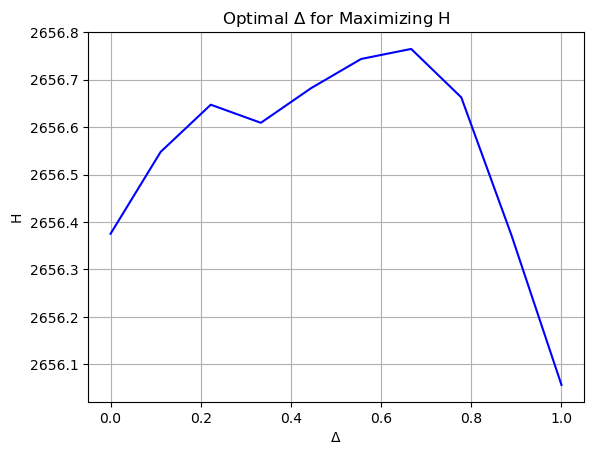

Optimal Delta: 0.7
Maximized H: 2656.8


In [21]:
# Define the range of delta values to test
delta_values = np.linspace(0, 1, 10)

# Find the optimal delta
optimal_delta, optimal_H = model2_new.find_optimal_delta(delta_values)

print("Optimal Delta:", round(optimal_delta, 1))
print("Maximized H:", round(optimal_H, 1))

The optimal $\Delta$ is 0.7. This suggests that the hairdresser company should not adjust employment so quickly. In stead, they should only update employment if optimal optimal employment is to a large extent greater than current employment. 


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.


**Answer for question 5:**
- An alternative policy that potential could improve profitability could be to increase the employment level by an arbitrary pct.-level of the profit difference from period t-1 to period t if profit is positive. 
- However, if profit is decreasing, the employment level could be cut by another arbitrary pct.-level of the profit difference from the previos period.  
- This policy could contribute to ensuring that there is a balance between positive and negative profit and the adjustment of employment level.
- We unfortunantly did not have time to try and implement this. 

## <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [22]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

**Answer for question 1:**

In [23]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

# 1.: Bounds and tolerance tau
bounds = [(-600, 600), (-600, 600)]
tau = 1e-8

# 2.: Warm-up and maximum number of iterations
K_wu = 10
K_max = 1000

def refined_global_optimizer(bounds, tol, K_wu, K_max):
    x_star = None # My initial best solution
    f_star = None # The function value to this best solution

    # 3.:
    for k in range(K_max):
        # 3.A: A random x_k is drawn uniformly within the bounds
        x_k = np.random.uniform(bounds[0], bounds[1])
        
        # 3.B-3.D: Iteration counter k
        if k >= K_wu:
            chi_k = 0.10*(2/(1+np.exp((k-K_wu)/100)))
            # The initial guess x_k0: based on the random x_k and previous best solution x_star:
            x_k0 = chi_k*x_k+(1-chi_k)*x_star 
        else:
            x_k0 = x_k
        
        # 3.E: Optimizer
        result = minimize(griewank, x_k0, method='BFGS', tol=tol)
        x_k_star = result.x
        f_k_star = result.fun
        
        # 3.F: Solution
        if k == 0 or f_k_star < f_star:
            x_star = x_k_star
            f_star = f_k_star
        
        # 3.G: if inside the tolerance value --> step 4
        if abs(f_star - tau) <= tau:
            break

    # 4: Result
    return x_star

optimal_solution = refined_global_optimizer(bounds, tau, K_wu, K_max)

print(f"Optimal x1 = {optimal_solution[0]:.2f}")
print(f"Optimal x2 = {optimal_solution[1]:.2f}")
print(f"Minimum value of the Griewank function: {griewank(optimal_solution):.2f}")



Optimal x1 = -599.70
Optimal x2 = 599.13
Minimum value of the Griewank function: 179.81


- The results of the above code suggest that a local minimum has been found, as the value of 179.8 cannot be considered close to the global minimum of 0. To find the global minimum, it is necessary to adjust the optimizer settings.

In [24]:
# Adding a warm-up phase
bounds = [(-600, 600), (-600, 600)]
tau = 1e-8
K_wu1 = 10
K_wu2 = 100
K_max = 1000
x0_values1 = []
x0_values2 = []

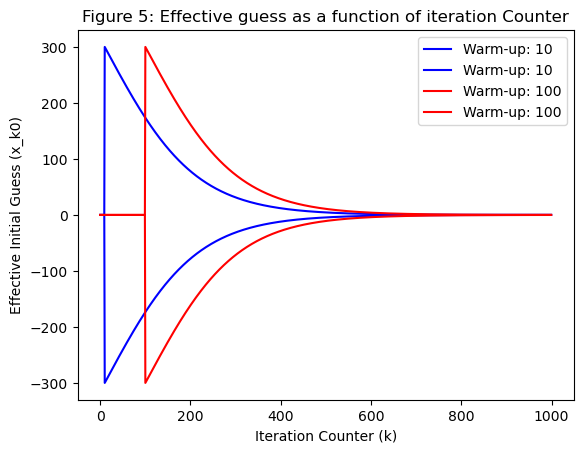

In [25]:
for k in range(K_max):
    x_k = np.random.uniform(bounds[0], bounds[1])
    chi_k1 = 0.50 * (2 / (1 + np.exp((k - K_wu1) / 100))) if k >= K_wu1 else 0
    chi_k2 = 0.50 * (2 / (1 + np.exp((k - K_wu2) / 100))) if k >= K_wu2 else 0
    x_k0_1 = chi_k1 * x_k
    x_k0_2 = chi_k2 * x_k
    x0_values1.append(x_k0_1)
    x0_values2.append(x_k0_2)

plt.plot(range(K_max), x0_values1, label='Warm-up: 10', color='blue')
plt.plot(range(K_max), x0_values2, label='Warm-up: 100', color='red')
plt.xlabel('Iteration Counter (k)')
plt.ylabel('Effective Initial Guess (x_k0)')
plt.title('Figure 5: Effective guess as a function of iteration Counter')
plt.legend()
plt.show()


- Figure 5 illustrates the variation of the effective initial guesses `x_k0` with the iteration counter `k`. As the iteration counter increases, the initial guess becomes closer to the global minimum we are searching for. However, the effectiveness of the optimization process is influenced by the duration of the warm-up period. 
- The initial effective guess is further away from the global minimum for lower values of iteration counters.
- As the iteration counter increases, the effective guess gets closer to the global minimum.

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

**Answer for question 2:**

In [26]:
optimal_solution1 = refined_global_optimizer(bounds, tau, K_wu1, K_max)
optimal_solution2 = refined_global_optimizer(bounds, tau, K_wu2, K_max)

optimal_solution1 = refined_global_optimizer(bounds, tau, K_wu1, K_max)
print("Optimal solution for Warm-up 10:")
print(f"x1 = {optimal_solution1[0]:.2f}")
print(f"x2 = {optimal_solution1[1]:.2f}")
print(f"Minimum value of the Griewank function: {griewank(optimal_solution1):.2f}")


optimal_solution2 = refined_global_optimizer(bounds, tau, K_wu2, K_max)
print("Optimal solution for Warm-up 100:")
print(f"x1 = {optimal_solution2[0]:.2f}")
print(f"x2 = {optimal_solution2[1]:.2f}")
print(f"Minimum value of the Griewank function: {griewank(optimal_solution2):.2f}")


Optimal solution for Warm-up 10:
x1 = -599.70
x2 = 599.13
Minimum value of the Griewank function: 179.81
Optimal solution for Warm-up 100:
x1 = -599.70
x2 = 599.13
Minimum value of the Griewank function: 179.81


- The purpose of the warm-up iterations phase (determined by the number of $\underline{K}$) is to gradually transition from random initial guesses to effective initial guesses based on the previous best solution.
- During the warm-up phase, the algorithm explores solutions solely based on randomness without considering the previous best solutions. This promotes exploration in a more freely-searched space.
- After the warm-up iterations, the algorithm starts incorporating the previous best solutions (`x_star`) in the calculations of the effective initial guess, enabling the exploitation of the process.
- The optimal number of $\underline{K}$ is determined by balancing exploration and exploitation, depending on the complexity of the search space.
- Figure 5 suggests that increasing the number of warm-up iterations from 10 to 100 does not significantly improve the results.
- The optimal solution for both warm-up phases is identical, indicating no improvement in the final solution for `x1` and `x2` by increasing the number of warm-up iterations.
- Since the global minimum of the Griewank function is known to be 0, the fact that the optimization process did not reach this global minimum suggests that the algorithm and parameter settings used were not sufficient.
- Increasing the warm-up period results in a slower convergence.
- Further adjustments are necessary to improve the optimization process and reach the global minimum.
